In [3]:
import os
import pandas as pd
from sqlalchemy import create_engine, text

DATABASE_NAME='data'
DATABASE_USERNAME='billinguser'
DATABASE_PASSWORD='Mglfya041100'
DATABASE_HOST='localhost'
DATABASE_PORT=5432

DATABASE_URL = f"postgresql://{DATABASE_USERNAME}:{DATABASE_PASSWORD}@{DATABASE_HOST}:{DATABASE_PORT}/{DATABASE_NAME}"


# Prefer importing your existing config (DATABASE_URL / engine)
try:
    engine = create_engine(DATABASE_URL, pool_pre_ping=True)
    print("Using DATABASE_URL from database_configuration.py")
except Exception as e:
    print("The was an error in the database configuration")

pd.set_option("display.max_rows", 20)
pd.set_option("display.width", 120)

# Se crea una función para correr de manera retorica 
def run_sql(sql: str, params: dict | None = None):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn, params=params or {})


Using DATABASE_URL from database_configuration.py


In [4]:
# Observamos la cantidad de simulaciones actuales
run_sql("SELECT COUNT(*) AS count FROM simulations;")

,count
0,960


In [11]:
prueba = run_sql("""
    SELECT *
    FROM simulations
    ORDER BY name;
""")
prueba

,id,name,duration_seconds,timestamp,num_people
0,660,test_simulation_p10_d1.5,652.8,2025-08-25 17:08:41.051011,10
1,658,test_simulation_p10_d1.5,672.6,2025-08-25 17:08:36.422013,10
2,657,test_simulation_p10_d1.5,643.6,2025-08-25 17:08:33.824425,10
3,656,test_simulation_p10_d1.5,679.4,2025-08-25 17:08:31.730165,10
4,655,test_simulation_p10_d1.5,683.4,2025-08-25 17:08:28.905794,10
...,...,...,...,...,...
955,955,test_simulation_p40_d4,920.4,2025-08-25 17:42:15.412283,40
956,956,test_simulation_p40_d4,925.4,2025-08-25 17:42:27.231031,40
957,957,test_simulation_p40_d4,864.8,2025-08-25 17:42:38.396769,40
958,958,test_simulation_p40_d4,912.0,2025-08-25 17:42:49.136290,40


In [ ]:
# Se 
query = """
  SELECT 
    -- Simulation Name
    pe.simulation_id,
    s.name AS simulation_name,
    -- Features of the simulation
    pe.id,
    pe.person_id,
    pe.exposure_time_seconds
  FROM person_exposures AS pe
  JOIN simulations AS s ON s.id = pe.simulation_id
  ORDER BY pe.exposure_time_seconds;
"""
run_sql(query)

,simulation_id,simulation_name,id,person_id,exposure_time_seconds
0,5,test_simulation_p10_d1.5,31,3,0.2
1,172,test_simulation_p30_d1.5,2144,13,0.2
2,9,test_simulation_p10_d1.5,51,9,0.2
3,339,test_simulation_p10_d1.5,6748,10,0.2
4,418,test_simulation_p20_d1.5,7419,14,0.2
...,...,...,...,...,...
19773,574,test_simulation_p40_d1.5,10873,6,742.4
19774,639,test_simulation_p40_d4,13100,3,742.6
19775,639,test_simulation_p40_d4,13085,11,746.6
19776,594,test_simulation_p40_d2.5,11574,14,754.4


In [ ]:
# Se 
query = """
  SELECT 
    -- Simulation Name
    le.simulation_id,
    s.name AS simulation_name,
    -- Features of the simulation
    le.id,
    le.x_coordinate,
    le.y_coordinate,
    le.exposure_time_seconds
  FROM location_exposures AS le
  JOIN simulations AS s ON s.id = le.simulation_id
  ORDER BY le.x_coordinate, le.y_coordinate, le.id;
"""
run_sql(query)

,simulation_id,simulation_name,id,x_coordinate,y_coordinate,exposure_time_seconds
0,639,test_simulation_p40_d4,14352,90,120,1.2
1,950,test_simulation_p40_d4,21213,90,120,1.2
2,948,test_simulation_p40_d4,21061,170,100,1.2
3,948,test_simulation_p40_d4,21062,180,100,1.2
4,954,test_simulation_p40_d4,21592,220,90,1.2
...,...,...,...,...,...,...
21967,767,test_simulation_p20_d3,15628,1660,920,225.2
21968,785,test_simulation_p20_d4,15900,1660,920,374.0
21969,810,test_simulation_p30_d1.5,16420,1660,920,57.2
21970,823,test_simulation_p30_d2.5,16669,1660,920,433.6


## Analísis de data

1) Load the three tables (joined where useful)

In [7]:
import pandas as pd
import numpy as np

# Simulations (base table)
df_sims = run_sql("""
    SELECT id, name, duration_seconds, timestamp, num_people
    FROM simulations
    ORDER BY timestamp;
""")

# Person exposures (join name for convenience)
df_pe = run_sql("""
    SELECT 
        pe.simulation_id,
        s.name AS simulation_name,
        pe.person_id,
        pe.exposure_time_seconds
    FROM person_exposures AS pe
    JOIN simulations AS s ON s.id = pe.simulation_id;
""")

# Location exposures (join name for convenience)
df_le = run_sql("""
    SELECT 
        le.simulation_id,
        s.name AS simulation_name,
        le.x_coordinate,
        le.y_coordinate,
        le.exposure_time_seconds
    FROM location_exposures AS le
    JOIN simulations AS s ON s.id = le.simulation_id;
""")

display(df_sims.head())
display(df_pe.head())
display(df_le.head())


,id,name,duration_seconds,timestamp,num_people
0,1,test_simulation_p10_d1.5,521.8,2025-08-25 14:44:53.319786,10
1,2,test_simulation_p10_d1.5,641.4,2025-08-25 14:44:55.937897,10
2,3,test_simulation_p10_d1.5,603.2,2025-08-25 14:44:58.268290,10
3,4,test_simulation_p10_d1.5,504.2,2025-08-25 14:45:00.061954,10
4,5,test_simulation_p10_d1.5,571.4,2025-08-25 14:45:02.247179,10


,simulation_id,simulation_name,person_id,exposure_time_seconds
0,1,test_simulation_p10_d1.5,3,28.0
1,1,test_simulation_p10_d1.5,6,3.0
2,1,test_simulation_p10_d1.5,5,83.8
3,1,test_simulation_p10_d1.5,2,136.2
4,1,test_simulation_p10_d1.5,8,7.6


,simulation_id,simulation_name,x_coordinate,y_coordinate,exposure_time_seconds
0,1,test_simulation_p10_d1.5,570,100,2.6
1,1,test_simulation_p10_d1.5,630,120,1.2
2,1,test_simulation_p10_d1.5,1600,880,128.4
3,1,test_simulation_p10_d1.5,1620,910,205.8
4,1,test_simulation_p10_d1.5,1630,900,127.4


2) Parse the scenario from name (pXX = people, dY.Y = distance in meters)

In [13]:
# Safe parsing even if name is NULL or oddly formatted
def parse_people(name):
    if not isinstance(name, str): return np.nan
    import re
    m = re.search(r'p(\d+)', name)
    return int(m.group(1)) if m else np.nan

def parse_distance(name):
    if not isinstance(name, str): return np.nan
    import re
    m = re.search(r'd(\d+(?:\.\d+)?)', name)
    return float(m.group(1)) if m else np.nan

df_sims['people_param'] = df_sims['name'].apply(parse_people)
df_sims['distance_m']   = df_sims['name'].apply(parse_distance)

# For joined frames as well (optional but handy)
if not df_pe.empty:
    df_pe['people_param'] = df_pe['simulation_name'].apply(parse_people)
    df_pe['distance_m']   = df_pe['simulation_name'].apply(parse_distance)

if not df_le.empty:
    df_le['people_param'] = df_le['simulation_name'].apply(parse_people)
    df_le['distance_m']   = df_le['simulation_name'].apply(parse_distance)

df_sims.head()


,id,name,duration_seconds,timestamp,num_people,people_param,distance_m
0,1,test_simulation_p10_d1.5,521.8,2025-08-25 14:44:53.319786,10,10,1.5
1,2,test_simulation_p10_d1.5,641.4,2025-08-25 14:44:55.937897,10,10,1.5
2,3,test_simulation_p10_d1.5,603.2,2025-08-25 14:44:58.268290,10,10,1.5
3,4,test_simulation_p10_d1.5,504.2,2025-08-25 14:45:00.061954,10,10,1.5
4,5,test_simulation_p10_d1.5,571.4,2025-08-25 14:45:02.247179,10,10,1.5


3) Simulation overview (counts, durations, per-scenario)

In [14]:
# Per simulation row (one row = one run)
overview = df_sims.assign(
    duration_min = df_sims['duration_seconds'] / 60.0
)[['id','name','people_param','distance_m','num_people','duration_seconds','duration_min','timestamp']]

# Aggregate by scenario name
agg_by_name = (
    overview
    .groupby(['name','people_param','distance_m','num_people'], dropna=False)
    .agg(
        runs=('id','count'),
        avg_duration_s=('duration_seconds','mean'),
        p50_duration_s=('duration_seconds','median'),
        p95_duration_s=('duration_seconds', lambda s: s.quantile(0.95)),
    )
    .reset_index()
    .sort_values(['people_param','distance_m','name'])
)

display(overview.head(10))
display(agg_by_name)


,id,name,people_param,distance_m,num_people,duration_seconds,duration_min,timestamp
0,1,test_simulation_p10_d1.5,10,1.5,10,521.8,8.696667,2025-08-25 14:44:53.319786
1,2,test_simulation_p10_d1.5,10,1.5,10,641.4,10.690000,2025-08-25 14:44:55.937897
2,3,test_simulation_p10_d1.5,10,1.5,10,603.2,10.053333,2025-08-25 14:44:58.268290
3,4,test_simulation_p10_d1.5,10,1.5,10,504.2,8.403333,2025-08-25 14:45:00.061954
4,5,test_simulation_p10_d1.5,10,1.5,10,571.4,9.523333,2025-08-25 14:45:02.247179
5,6,test_simulation_p10_d1.5,10,1.5,10,492.0,8.200000,2025-08-25 14:45:04.604639
6,7,test_simulation_p10_d1.5,10,1.5,10,714.0,11.900000,2025-08-25 14:45:07.335639
7,8,test_simulation_p10_d1.5,10,1.5,10,455.4,7.590000,2025-08-25 14:45:09.371161
8,9,test_simulation_p10_d1.5,10,1.5,10,803.4,13.390000,2025-08-25 14:45:11.927233
9,10,test_simulation_p10_d1.5,10,1.5,10,658.8,10.980000,2025-08-25 14:45:14.658983


,name,people_param,distance_m,num_people,runs,avg_duration_s,p50_duration_s,p95_duration_s
0,test_simulation_p10_d1.5,10,1.5,10,60,632.876667,629.8,774.27
1,test_simulation_p10_d2.5,10,2.5,10,60,635.373333,630.4,743.88
2,test_simulation_p10_d3,10,3.0,10,60,634.593333,630.2,758.97
3,test_simulation_p10_d4,10,4.0,10,60,632.926667,622.5,772.52
4,test_simulation_p20_d1.5,20,1.5,20,60,707.673333,708.2,815.31
5,test_simulation_p20_d2.5,20,2.5,20,60,721.283333,718.6,826.57
6,test_simulation_p20_d3,20,3.0,20,60,715.833333,708.3,806.42
7,test_simulation_p20_d4,20,4.0,20,60,692.890000,691.4,796.61
8,test_simulation_p30_d1.5,30,1.5,30,60,777.866667,773.1,851.44
9,test_simulation_p30_d2.5,30,2.5,30,60,791.846667,792.5,888.00


4) Person-level exposure metrics per simulation (and scenario)

In [15]:
# Summary per simulation_id
if df_pe.empty:
    print("No rows in person_exposures.")
    pe_sim_summary = pd.DataFrame()
else:
    grp = df_pe.groupby(['simulation_id'], as_index=False)['exposure_time_seconds']
    pe_sim_summary = grp.agg(
        exposed_count = 'count',
        total_exposure_s = 'sum',
        mean_exposure_s = 'mean',
        median_exposure_s = 'median',
        p95_exposure_s = lambda s: s.quantile(0.95),
        max_exposure_s = 'max'
    )

# Join with simulations to compute percent exposed
pe_sim_summary = pe_sim_summary.merge(
    df_sims[['id','name','num_people','people_param','distance_m']],
    left_on='simulation_id', right_on='id', how='right'
)

# If a simulation had zero exposures, fill with zeros
for col in ['exposed_count','total_exposure_s','mean_exposure_s','median_exposure_s','p95_exposure_s','max_exposure_s']:
    pe_sim_summary[col] = pe_sim_summary[col].fillna(0)

pe_sim_summary['pct_exposed'] = np.where(
    pe_sim_summary['num_people'] > 0,
    pe_sim_summary['exposed_count'] / pe_sim_summary['num_people'],
    np.nan
)

# Nice view
pe_sim_summary_sorted = pe_sim_summary.sort_values(['people_param','distance_m','simulation_id'])
display(pe_sim_summary_sorted.head(20))

# Aggregate per scenario name
pe_by_name = (
    pe_sim_summary
    .groupby(['name','people_param','distance_m','num_people'], dropna=False)
    .agg(
        runs=('simulation_id','count'),
        avg_pct_exposed=('pct_exposed','mean'),
        avg_total_exposure_s=('total_exposure_s','mean'),
        avg_mean_exposure_s=('mean_exposure_s','mean')
    )
    .reset_index()
    .sort_values(['people_param','distance_m'])
)
display(pe_by_name)


,simulation_id,exposed_count,total_exposure_s,mean_exposure_s,median_exposure_s,p95_exposure_s,max_exposure_s,id,name,num_people,people_param,distance_m,pct_exposed
0,1.0,7.0,513.0,73.285714,83.8,133.50,136.2,1,test_simulation_p10_d1.5,10,10,1.5,0.7
1,2.0,8.0,1044.4,130.550000,152.1,263.83,264.6,2,test_simulation_p10_d1.5,10,10,1.5,0.8
3,4.0,7.0,1046.8,149.542857,118.2,272.66,285.2,4,test_simulation_p10_d1.5,10,10,1.5,0.7
4,5.0,9.0,1375.4,152.822222,128.8,268.92,269.0,5,test_simulation_p10_d1.5,10,10,1.5,0.9
5,6.0,6.0,524.6,87.433333,65.5,192.40,193.0,6,test_simulation_p10_d1.5,10,10,1.5,0.6
7,8.0,6.0,329.0,54.833333,22.2,184.30,229.8,8,test_simulation_p10_d1.5,10,10,1.5,0.6
8,9.0,8.0,1983.4,247.925000,298.0,430.73,430.8,9,test_simulation_p10_d1.5,10,10,1.5,0.8
9,10.0,8.0,1462.6,182.825000,187.8,361.59,366.0,10,test_simulation_p10_d1.5,10,10,1.5,0.8
10,11.0,8.0,788.2,98.525000,99.5,188.19,188.4,11,test_simulation_p10_d1.5,10,10,1.5,0.8
12,13.0,9.0,422.2,46.911111,1.4,217.64,259.4,13,test_simulation_p10_d1.5,10,10,1.5,0.9


,name,people_param,distance_m,num_people,runs,avg_pct_exposed,avg_total_exposure_s,avg_mean_exposure_s
0,test_simulation_p10_d1.5,10,1.5,10,51,0.665000,788.576667,103.186184
1,test_simulation_p10_d2.5,10,2.5,10,52,0.708333,1143.350000,140.932963
2,test_simulation_p10_d3,10,3.0,10,53,0.713333,1182.173333,147.148339
3,test_simulation_p10_d4,10,4.0,10,52,0.710000,1297.273333,161.650788
4,test_simulation_p20_d1.5,20,1.5,20,56,0.771667,2633.223333,160.633066
5,test_simulation_p20_d2.5,20,2.5,20,56,0.793333,3801.756667,225.727101
6,test_simulation_p20_d3,20,3.0,20,57,0.792500,3935.383333,237.493206
7,test_simulation_p20_d4,20,4.0,20,60,0.860833,3948.433333,230.547741
8,test_simulation_p30_d1.5,30,1.5,30,60,0.835000,5910.853333,236.776314
9,test_simulation_p30_d2.5,30,2.5,30,60,0.850556,7454.433333,293.437710


5) Location “hotspots” (where exposure accumulates)

In [16]:
if df_le.empty:
    print("No rows in location_exposures.")
    hotspots_all = pd.DataFrame()
else:
    # Sum exposure by coordinate across ALL runs
    hotspots_all = (
        df_le
        .groupby(['x_coordinate','y_coordinate'], as_index=False)['exposure_time_seconds']
        .sum()
        .rename(columns={'exposure_time_seconds':'total_exposure_s'})
        .sort_values('total_exposure_s', ascending=False)
    )

display(hotspots_all.head(20))

# Top hotspots per scenario (example: p40, d4)
example = df_le[(df_le['people_param']==40) & (df_le['distance_m']==4.0)]
hotspots_example = (
    example
    .groupby(['x_coordinate','y_coordinate'], as_index=False)['exposure_time_seconds']
    .sum()
    .rename(columns={'exposure_time_seconds':'total_exposure_s'})
    .sort_values('total_exposure_s', ascending=False)
)
display(hotspots_example.head(20))


,x_coordinate,y_coordinate,total_exposure_s
1119,1630,910,848635.8
995,1590,880,722138.0
1093,1620,910,674774.6
1123,1640,910,480459.8
1009,1600,880,412863.4
1118,1630,900,364297.0
1125,1650,910,298126.2
1092,1620,900,271000.6
1094,1620,920,241623.6
1124,1650,900,230891.8


,x_coordinate,y_coordinate,total_exposure_s
896,1630,910,110784.4
791,1590,880,96624.2
874,1620,910,77446.0
900,1640,910,54465.6
800,1600,880,52690.8
895,1630,900,44585.0
873,1620,900,43301.2
902,1650,910,37101.0
901,1650,900,28835.2
875,1620,920,28649.8


How exposure scales with distance and people (simple visuals)

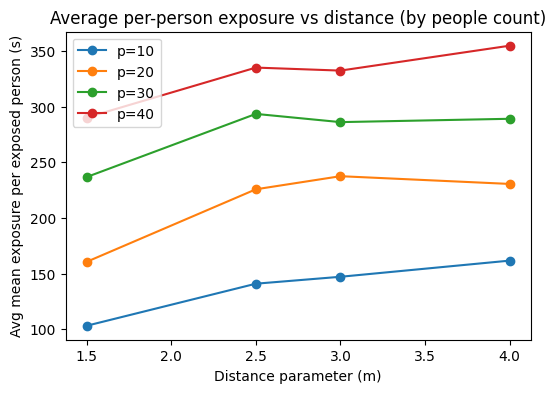

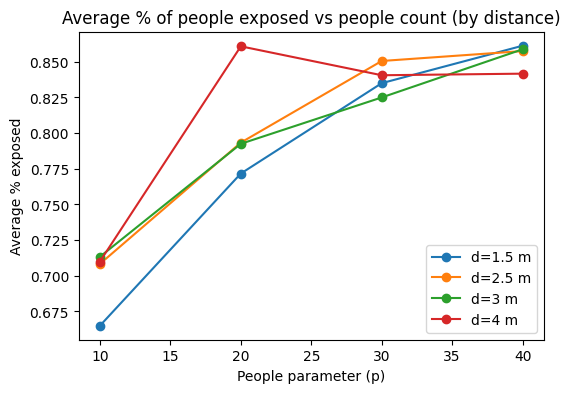

In [17]:
import matplotlib.pyplot as plt

# Per-scenario averages from step 4
if not pe_by_name.empty:
    # Distance vs Avg Mean Exposure (averaged across runs)
    plt.figure(figsize=(6,4))
    for p in sorted(pe_by_name['people_param'].dropna().unique()):
        sub = pe_by_name[pe_by_name['people_param']==p]
        plt.plot(sub['distance_m'], sub['avg_mean_exposure_s'], marker='o', label=f'p={int(p)}')
    plt.title('Average per-person exposure vs distance (by people count)')
    plt.xlabel('Distance parameter (m)')
    plt.ylabel('Avg mean exposure per exposed person (s)')
    plt.legend()
    plt.show()

    # People vs Avg % Exposed (fixing distance by plotting separate lines)
    plt.figure(figsize=(6,4))
    for d in sorted(pe_by_name['distance_m'].dropna().unique()):
        sub = pe_by_name[pe_by_name['distance_m']==d]
        sub = sub.sort_values('people_param')
        plt.plot(sub['people_param'], sub['avg_pct_exposed'], marker='o', label=f'd={d:g} m')
    plt.title('Average % of people exposed vs people count (by distance)')
    plt.xlabel('People parameter (p)')
    plt.ylabel('Average % exposed')
    plt.legend()
    plt.show()
else:
    print("pe_by_name is empty; run step 4 first.")


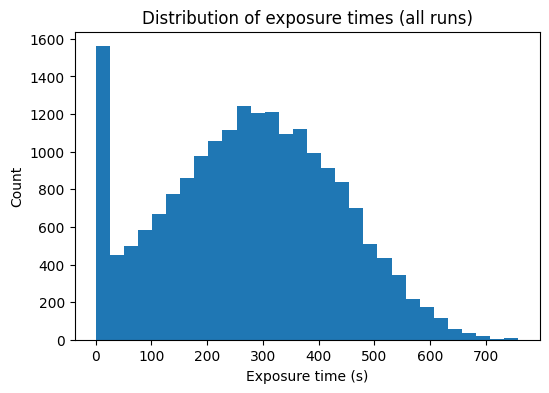

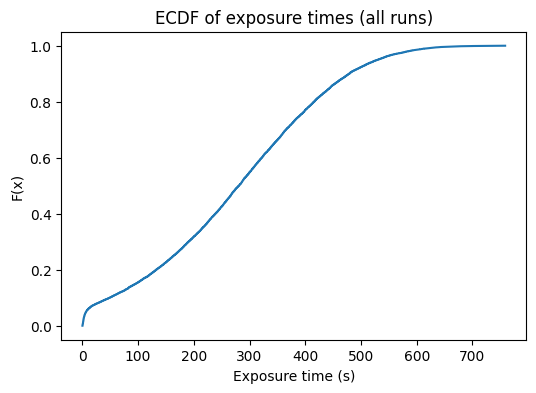

In [18]:
if not df_pe.empty:
    plt.figure(figsize=(6,4))
    df_pe['exposure_time_seconds'].plot(kind='hist', bins=30)
    plt.title('Distribution of exposure times (all runs)')
    plt.xlabel('Exposure time (s)')
    plt.ylabel('Count')
    plt.show()

    # ECDF (empirical CDF)
    x = np.sort(df_pe['exposure_time_seconds'].to_numpy())
    y = np.arange(1, len(x)+1) / len(x)
    plt.figure(figsize=(6,4))
    plt.plot(x, y)
    plt.title('ECDF of exposure times (all runs)')
    plt.xlabel('Exposure time (s)')
    plt.ylabel('F(x)')
    plt.show()


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re

# Set up the visualization style
plt.style.use('default')
sns.set_palette("husl")

In [13]:
# 1) Load person_exposures with simulation metadata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_pe = run_sql("""
    SELECT 
        pe.simulation_id,
        s.name AS simulation_name,
        s.num_people,
        pe.person_id,
        pe.exposure_time_seconds
    FROM person_exposures AS pe
    JOIN simulations AS s ON s.id = pe.simulation_id;
""")

if df_pe.empty:
    raise SystemExit("No rows in person_exposures.")

# Parse people count from simulation_name (e.g., 'test_simulation_p10_d1.5' -> 10)
import re
def parse_people(name):
    if not isinstance(name, str): return np.nan
    m = re.search(r'p(\d+)', name)
    return int(m.group(1)) if m else np.nan

df_pe["people_param"] = df_pe["simulation_name"].apply(parse_people)
df_pe = df_pe.dropna(subset=["people_param"]).copy()
df_pe["people_param"] = df_pe["people_param"].astype(int)
sorted_people = sorted(df_pe["people_param"].unique())
sorted_people


[np.int64(10), np.int64(20), np.int64(30), np.int64(40)]

In [14]:
# 2) Build exposure-time bins and compute distributions per people count
# Adjust bins to your data scale if needed
bin_edges = [0, 1, 2, 5, 10, 20, 40, 60, np.inf]
bin_labels = ["0–1", "1–2", "2–5", "5–10", "10–20", "20–40", "40–60", "60+"]

df_pe["exp_bin"] = pd.cut(df_pe["exposure_time_seconds"], bins=bin_edges, labels=bin_labels, right=False)

# counts per people_param and bin
counts = (
    df_pe.groupby(["people_param", "exp_bin"], dropna=False)
         .size()
         .reset_index(name="count")
)

# Normalize to percentages within each people_param (so bars sum to 100%)
counts["pct"] = counts.groupby("people_param")["count"].transform(lambda s: s / s.sum() * 100)

# Ensure all bins exist for each people_param
full_index = pd.MultiIndex.from_product([sorted_people, bin_labels], names=["people_param","exp_bin"])
counts = counts.set_index(["people_param","exp_bin"]).reindex(full_index, fill_value=0).reset_index()
counts.head(12)


/tmp/ipykernel_8448/1278344999.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_pe.groupby(["people_param", "exp_bin"], dropna=False)


,people_param,exp_bin,count,pct
0,10,0–1,31,1.847437
1,10,1–2,93,5.542312
2,10,2–5,111,6.615018
3,10,5–10,60,3.575685
4,10,10–20,57,3.396901
5,10,20–40,55,3.277712
6,10,40–60,94,5.601907
7,10,60+,1177,70.143027
8,20,0–1,58,1.501813
9,20,1–2,80,2.071466


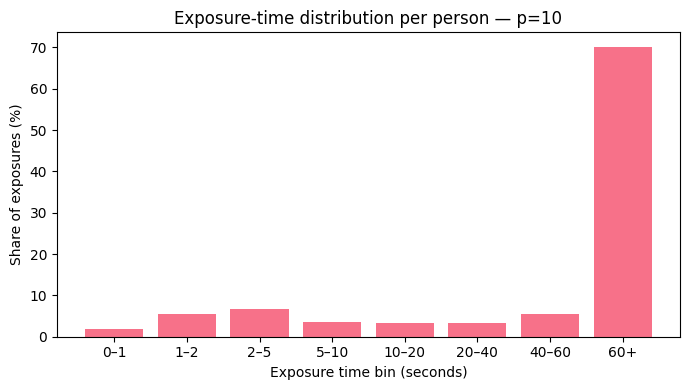

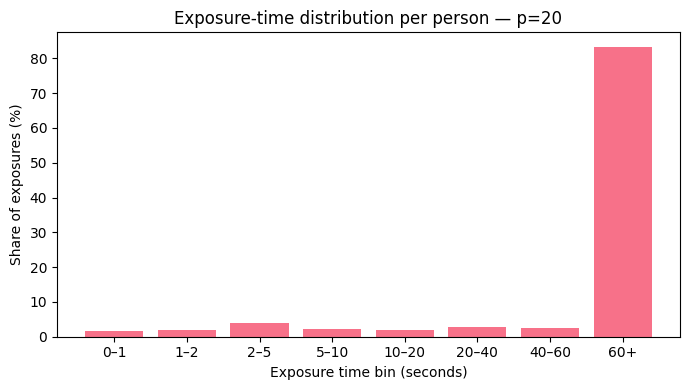

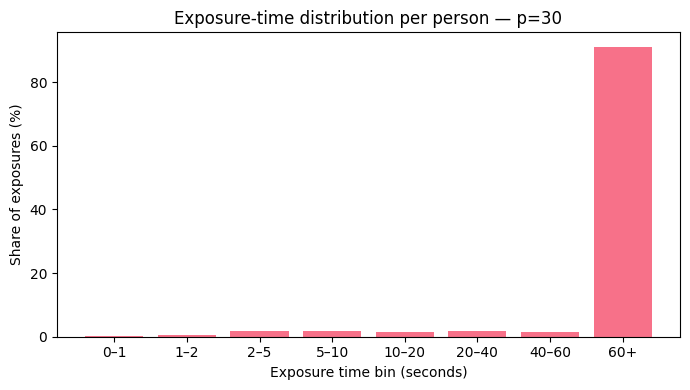

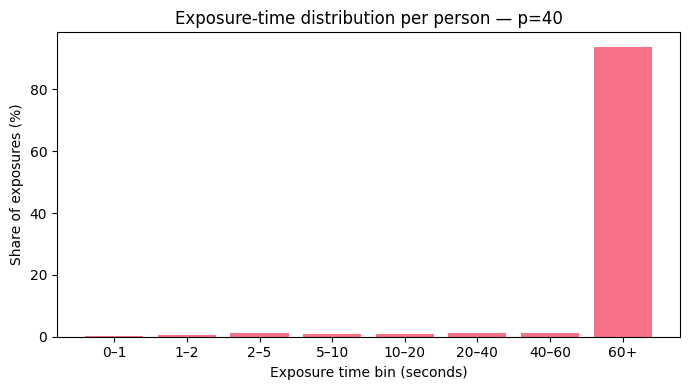

In [15]:
# 3) Plot a bar distribution for EACH people count
for p in sorted_people:
    sub = counts[counts["people_param"] == p].copy()
    plt.figure(figsize=(7,4))
    plt.bar(sub["exp_bin"].astype(str), sub["pct"])
    plt.title(f"Exposure-time distribution per person — p={p}")
    plt.xlabel("Exposure time bin (seconds)")
    plt.ylabel("Share of exposures (%)")
    plt.tight_layout()
    plt.show()


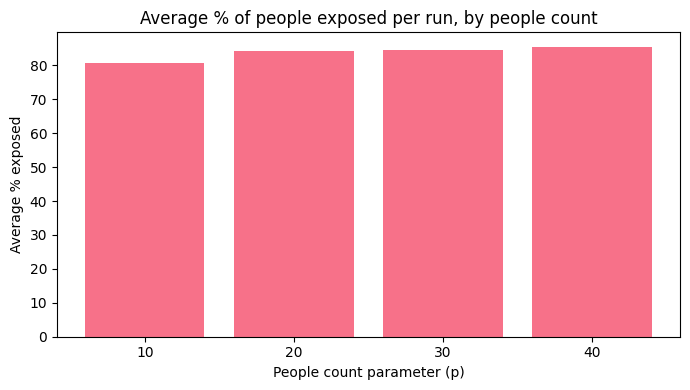

In [16]:
# 4) Summary bars: average % of people exposed per simulation, grouped by people count

# Compute exposures per simulation_id
per_sim = (
    df_pe.groupby(["simulation_id", "simulation_name", "people_param"], as_index=False)
         .agg(exposed_count=("person_id","nunique"))
)

# Bring in num_people to compute % exposed (unique persons per sim)
sim_people = run_sql("SELECT id AS simulation_id, num_people FROM simulations;")

per_sim = per_sim.merge(sim_people, on="simulation_id", how="left")
per_sim["pct_exposed"] = np.where(per_sim["num_people"]>0, per_sim["exposed_count"]/per_sim["num_people"]*100, np.nan)

# Average over all runs (and distances) for each people count
avg_pct_by_people = (
    per_sim.groupby("people_param", as_index=False)["pct_exposed"]
           .mean()
           .sort_values("people_param")
)

plt.figure(figsize=(7,4))
plt.bar(avg_pct_by_people["people_param"].astype(str), avg_pct_by_people["pct_exposed"])
plt.title("Average % of people exposed per run, by people count")
plt.xlabel("People count parameter (p)")
plt.ylabel("Average % exposed")
plt.tight_layout()
plt.show()


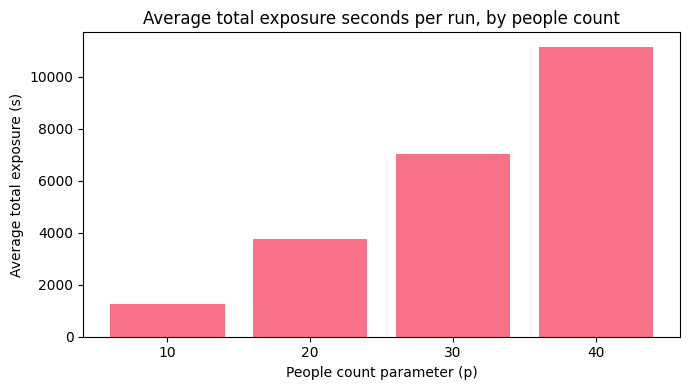

In [17]:
# 5) (Optional) Another summary: average total exposure seconds per run, by people count
# Sum exposure seconds per simulation_id, then average across runs for each p
totals_per_sim = (
    df_pe.groupby(["simulation_id","people_param"], as_index=False)["exposure_time_seconds"]
         .sum()
         .rename(columns={"exposure_time_seconds":"total_exposure_s"})
)

avg_total_by_people = (
    totals_per_sim.groupby("people_param", as_index=False)["total_exposure_s"]
                  .mean()
                  .sort_values("people_param")
)

plt.figure(figsize=(7,4))
plt.bar(avg_total_by_people["people_param"].astype(str), avg_total_by_people["total_exposure_s"])
plt.title("Average total exposure seconds per run, by people count")
plt.xlabel("People count parameter (p)")
plt.ylabel("Average total exposure (s)")
plt.tight_layout()
plt.show()


In [14]:
engine.dispose()